## Classic Encoder-Decoder Transformer Architecture

In [2]:
import sys
sys.path.insert(-1, '/home/hschia/ml')
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
from d2l import torch as d2l
import sequence as seq

import torch
from torch import nn

In [3]:
torch.cuda.is_available()

True

### Setup

In [5]:
def sequence_mask(X, valid_len, value=1e10):
    """Mask irrelevant entries in sequence, such as '<pad>', by setting their values to 'value'.
       X: 2D data tensor
       valid_len: 1D tensor (with shape X.shape[0]), with each element denoting the first number of entries of X along dim=1 to keep"""
    
    maxlen = X.size(1) # same as X.shape[1] (n_keys)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None,:] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
    """Perform softmax operation (on attention score) with 
       mask applied to th elements on the last axis.
       Shape of X: (num_batch, no. of queries, no. of keys).
       Shape of valid_lens: (num_batch) or (num_batch, no. of queries)."""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1) # Flatten to 1D array
        # On the last axis, replace masked elements with a very large negative value, 
        # whose exponentiation outputs 0 (TODO: how is this upper triangle?)
        X = seq.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class DotProductAttention(nn.Module):
    """Dot product attention."""
    def __init__(self, dropout, **kwargs):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens=None):
        """In dot product attention, d = key_size = query_size."""
        d = keys.shape[-1]         
        # Shape of scores and attention_weights: (batch_size, no. of queries, no. of keys)
        # Shape of y_hat: (batch_size, no. of queries, value_size)
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        y_hat = torch.bmm(self.dropout(self.attention_weights), values)
        return y_hat

In [13]:
def transpose_qkv(X, num_heads):
    """
    Transpose QKV for parallel computation in multihead attention mechanism. 
    Converts X of initial shape: (batch_size, no. of queries or key-value pairs, num_hiddens) to
    final shape: (batch_size * num_heads, no. of queries or key-value pairs, num_hiddens/num_heads), ie.
    basically downsizes num_hiddens by num_heads and simultaneously enlarge the effective batch_size.
    """
    # Shape of input X: (batch_size, no. of queries or key-value pairs, num_hiddens)
    # Shape of output X: (batch_size, no. of queries or key-value pairs, num_heads, num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value pairs, num_hiddens/num_heads)
    X = X.permute(0,2,1,3)
    # Shape of output X: (batch_size * num_heads, no. of queries or key-value pairs, num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0,2,1,3)
    return X.reshape(X.shape[0], X.shape[1], -1)

class MultiHeadAttention(nn.Module):
    """Multi-head attention using the dot product attention."""
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        """
        We first perform linear transformations on qkv before splitting them into multiheads. Therefore,
        key_size: total dimension of key feature vector (before splitting into multiheads)
        query_size: total dimension of query feature vector (before splitting into multiheads)
        value_size: total dimension of value feature vector (before splitting into multiheads)
        num_hiddens: total hidden dimension (before splitting into multiheads)
        
        In dot product attention, key_size = query_size
        In self-attention mechanism, key_size = query_size = value_size
        In multi-head attention, the ratio num_hiddens/num_heads must be an integer
        To faciliate skip connection, we always the num_hiddens (d_model) of qkv to be the same
        """
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias) # key_size = query_size
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        # W_o input_size = num_hiddens since we apply W_o after concatenating multiheads
        # W_o output_size = value_size in order to restore original DotProductAttention shape
        self.W_o = nn.Linear(num_hiddens, value_size, bias=bias) 
        
    def forward(self, queries, keys, values, valid_lens):
        # Shape of qkv inputs: (batch_size, no. of queries or key-value pairs, query or num_hiddens)
        # After transposing: (batch_size * num_heads, no. of queries or key-value pairs, num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        
        # Shape of output: (batch_size * num_heads, no. of queries, num_hiddens/num_heads)
        # Shape of output_concat: (batch_size , no. of queries, num_hiddens)
        # Shape of final output: (batch_size, no. of queries, value_size)
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)
    
    
    
class PositionalEncoding(nn.Module):
    """
    Positional encoding using the sines and cosines of the original Transformer paper.
    Dropout is applied to X+P as a form of regularization.
    """
    def __init__(self, embedding_dim, dropout, max_len=1000, **kwargs):
        """
        max_len: sufficiently large number such that >> no. of queries.
        query_size: embedding dimension.
        (Note: In the Transformer paper, embedding_dim = num_hiddens. This is needed
        because we want to use skip connections to sum input X with output of sublayers.)
        """
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Shape of X and P: (batch_size, no. of queries, embedding_dim)
        self.P = torch.zeros((1,max_len, embedding_dim))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1,1) / torch.pow(10000, torch.arange(0, embedding_dim, 2, dtype=torch.float32) / embedding_dim) # broadcasting!
        self.P[:,:,0::2] = torch.sin(X)
        self.P[:,:,1::2] = torch.cos(X)
        
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device) # Add up to maximum no. of queries in X
        return self.dropout(X)

class PositionWiseFFN(nn.Module):
    """Apply the same MLP to the feature vector at every sequence position. """
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_output, **kwargs):
        """
        Since we will use AddNorm along with this FFN, we will demand ffn_num_input = ffn_num_output.
        Further, since this FFN will be applied after multihead attention, we will demand ffn_num_input = value_size.
        """
        super().__init__()
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_output)
        
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

class AddNorm(nn.Module):
    """ 
    Apply LayerNorm(X + Y), where Y = f(X) is in principle an arbitrary function. 
    In practice, f(X) is either MultiHeadAttention or PositionWiseFFN.
    Dropout is applied to Y for regularization.
    """
    def __init__(self, normalized_shape, dropout, **kwargs):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        # Shape of X, Y = shape of output
        return self.ln(self.dropout(Y) + X)
    
    

In [18]:
class EncoderBlock(nn.Module):
    """Transformer encoder block (also known as encoder layer)."""
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, 
                                            num_heads, dropout, bias, **kwargs)
        self.addnorm1 = AddNorm(norm_shape, dropout, **kwargs)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, ffn_num_input, **kwargs)
        self.addnorm2 = AddNorm(norm_shape, dropout, **kwargs)
        
    def forward(self, X, enc_valid_lens):
        # Shape of X, Y and final output: (batch_size, no. of queries, value_size)
        # In self-attention mechanism, query_size = key_size = value_size
        # enc_valid_lens is initiated in data_iter (computed in load_data_nmt for every sequence)
        Y = self.addnorm1(X, self.attention(X, X, X, enc_valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

class TransformerEncoder(seq.Encoder):
    """TODO: Understand sqrt(num_hiddens) part. Transformer encoder."""
    def __init__(self, num_layers, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, num_heads, dropout, bias=False, **kwargs):
        """
        Combining the constraints in MultiHeadAttention and PositionWiseFFN, we have
        query_size = key_size = value_size = ffn_num_input. The Transformer model makes 
        the further simplification that num_hiddens is equal to these input variables.
        """
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            # add_module(name, module) is a method of the nn.Module base class
            self.blks.add_module("block"+str(i), 
                EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, num_heads, dropout, bias))
        
    def forward(self, X, enc_valid_lens, *args):
        # Initialize X+P and attention_weights
        # Shape of input X: (batch_size, no. of queries)
        # Shape of output X after embedding: (batch_size, no. of queries, query_size)
        
        # Since our sine/cosine positional embedding values are between -1 and 1, 
        # the embedding values are multiplied by the sqrt of the embedding dimension 
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens)) # TODO: Still don't understand this, also should be query_size? 
        self.attention_weights = [None] * len(self.blks)
        
        # Pass data through every encoder block
        for i, blk in enumerate(self.blks):
            X = blk(X, enc_valid_lens) # feed on itself
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [19]:
class DecoderBlock(nn.Module):
    """ TODO: Understand self.training and dec_valid_lens parts
    The i-th block of the decoder. Unlike the encoder block, here we bookkeep the index i 
    to store the keys_values of former time steps for predictions in future time steps
    (see NLP lecture notes 14 slide 27 for illustration). 
    """
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super().__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, 
                                             num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, 
                                             num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, ffn_num_input)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, state):
        """
        Combine the output embedding, X, and the decoder hidden state in the decoder.
        State is a tuple of (enc_outputs, enc_valid_lens, dec_keys), where 
        enc_outputs: the output of the encoder's final block, 
        enc_valid_lens: the encoder valid lengths (precomputed in load_data_nmt for each sequence),
        dec_cumulative_keys_values: the keys and values accumulated in the decoder for future 
                                    prediction time steps to attend to.
        """
        # Shape of X: (batch_size, no. of queries, query_size)
        # Shape of enc_outputs: (batch_size, no. of queries, value_size)
        # Shape of enc_valid_lens: no. of queries or (batch_size, no. of queries)
        # Shape of dec_cumulative_keys_values: (batch_size, range(1, no. of queries+1) * no. of queries, 
        # query_size), where the range depends on the prediction time step
        enc_outputs, enc_valid_lens = state[0], state[1]
        
        # During training and in the first prediction step, all the tokens of any output sequence
        # are processed at the same time, so state[2][self.i] is initialized as None. In this case,
        # keys = values = queries and we therefore perform vanilla self_attention(X, X, X)
        if state[2][self.i] is None:
            keys_values = X
        # After first prediction step, when decoding any output sequence token we want 'state[2][self.i]'
        # to contain representations of the decoded output at the i-th block up to the current time step,
        # such that the current query can attend to all past keys and values 
        else:
            keys_values = torch.cat((state[2][self.i], X), axis=1) # axis 1 would grow linearly over time steps
        state[2][self.i] = keys_values
        
        # Shouldn't the following be testing? Confused.
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, no. of queries), where every row is
            # [1,2,3, ..., no. of queries] to preserve autoregressive behaviour during prediction
            dec_valid_lens = torch.arange(1, 
                num_steps+1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
            
        # Self attention 
        # Regardless of the size of keys_values[1], the shape of X2 is always(batch_size, no. of queries, value_size)
        X2 = self.attention1(X, keys_values, keys_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        
        # Encoder-decoder (Bahdanau) attention
        # Since we use dot product between q_decoder and k_encoder in cross-attention, query_size = key_size = value_size
        # Shape of Y and enc_outputs: (batch_size, no. of queries or key-value pairs, value_size)
        # Shape of final output: (batch_size, no. of queries, value_size)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        # enc_outputs and enc_valid_lens remain the fixed throughout ; only the decoder QKV changes
        return self.addnorm3(Z, self.ffn(Z)), state

In [21]:
class TransformerDecoder(seq.AttentionDecoder):
    """TODO: Understand sqrt(num_hiddens) part. Transformer decoder."""
    def __init__(self, num_layers, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, num_heads, dropout, bias=False):
        """
        Combining the constraints in MultiHeadAttention and PositionWiseFFN, we have
        query_size = key_size = value_size = ffn_num_input. The Transformer model makes 
        the further simplification that num_hiddens is equal to these input variables.
        """
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module('block'+str(i), 
                DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.Linear(value_size, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        """
        Initialize decoder state by taking in encoder inputs. The final entry is set to
        None in every decoder layer for training and for the initial prediction step.
        """
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens)) # TODO: Still don't understand this, also should be query_size?
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights        

In [23]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 500, d2l.try_gpu()
key_size = query_size = value_size = 32
ffn_num_input, ffn_num_hiddens, num_heads = value_size, 64, 4
norm_shape = [num_hiddens]

train_iter, src_vocab, tgt_vocab = seq.load_data_nmt('fra-eng', 'fra', batch_size, num_steps)

encoder = TransformerEncoder(num_layers, len(src_vocab), key_size, query_size, value_size, num_hiddens, 
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout)
decoder = TransformerDecoder(num_layers, len(tgt_vocab), key_size, query_size, value_size, num_hiddens, 
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout)
net = seq.EncoderDecoder(encoder, decoder)

loss 0.138, 24929.0 tokens/sec on cuda:0
CPU times: user 7h 58min 54s, sys: 46.9 s, total: 7h 59min 41s
Wall time: 7h 36min 4s


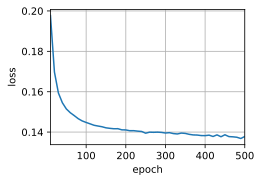

In [24]:
%%time
start = time.time()
animator, metric = seq.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)
wall_time = time.time() - start

In [25]:
wall_time / 3600

7.6011370073424445

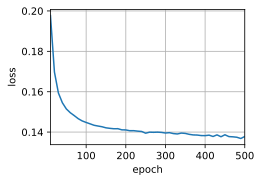

In [26]:
animator.fig

In [27]:
torch.save(net, 'transformer_tmp.pt')
# animator.fig.savefig('/home/hschia/ml/models/machine_translation/transformer_tmp.pdf', bbox_inches='tight', dpi=256)

In [28]:
engs = ['go .', 'i am lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = seq.predict_seq2seq(net, 
                                        eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, BLEU {seq.bleu(translation, fra, k=2):.3f}')

go . => allez !, BLEU 0.000
i am lost . => je suis perdu ., BLEU 0.385
he's calm . => il est calme ., BLEU 1.000
i'm home . => je suis chez moi ., BLEU 1.000


In [29]:
sum([p.numel() for p in net.parameters()])

1522748